In [13]:
"""
Reimplementing in python Fig5_Terminal_constraints/scenario1_tc.m
"""
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


In [2]:
# Network params
NETWORK = 4
LOCALITY = 3

# State dimensions
N = NETWORK   # number of pendulums
NX = 2*N      # each pendulum has 2 states (theta, dtheta)
NU = N        # each pendulum has only dtheta actuated

# System params
m = 1         # [kg] mass of the pendulum
k = 1         # [N/m] spring constant
d = 3         # [Ns/m] damping constant
g = 10        # [m/s^2] gravity
l = 1         # [m] length of pendulum

# Scenario parameters
d = LOCALITY
x0 = 0.5 * np.ones((NX, 1))
T = 10

In [3]:
# Construct dynamic system matrices: dx = Ax + Bu
block_off_diag = np.array([[0,0], [k*l/m, d/m/l]])
block_diag_extra = np.array([[0, 1], [-g-k*l/m, -d/(m*l)]])
block_diag = np.array([[0, 1], [-g-2*k*l/m, -2*d/(m*l)]])

Ac = np.zeros((NX, NX))
Bc = np.zeros((NX, NU))
for j, i in enumerate(range(0, NX, 2)):
  Ac[i:i+2,i:i+2] = block_diag
  if j!=N-1:
    Ac[i:i+2,i+2:i+4] = block_off_diag
  if j!=0:
    Ac[i:i+2,i-2:i] = block_off_diag

  Bc[i:i+2, j] = np.array([0, 1])

In [4]:
# Discretize system
TS = .1       # [s] sampling time

A = np.eye(NX) + TS * Ac
B = TS * Bc

Text(0.5, 1.0, 'Unactuated system')

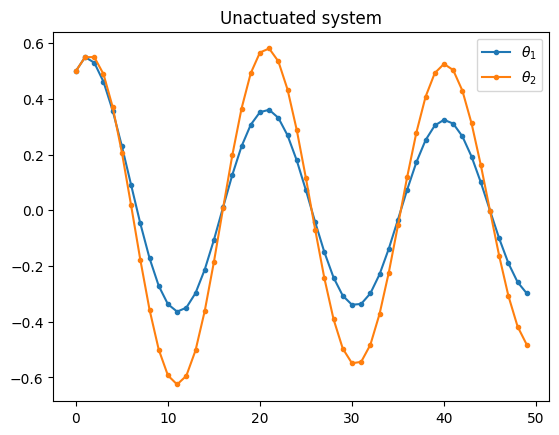

In [52]:
# scenario testing
Tsim = 50
x_history = np.zeros((Tsim, 1, NX))
x_history[0] = x0.T
for t in range(Tsim-1):
  x_history[t+1] = (A @ x_history[t].T).T

plt.plot(np.arange(0, Tsim), x_history[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim), x_history[:, 0, 2], ".-", label="$\\theta_2$")
plt.title("Unactuated system")
plt.legend(loc="best")

In [22]:
# cost matrices
Q = np.eye(NX)
S = np.eye(NU)

Text(0.5, 1.0, 'Centralized MPC controller')

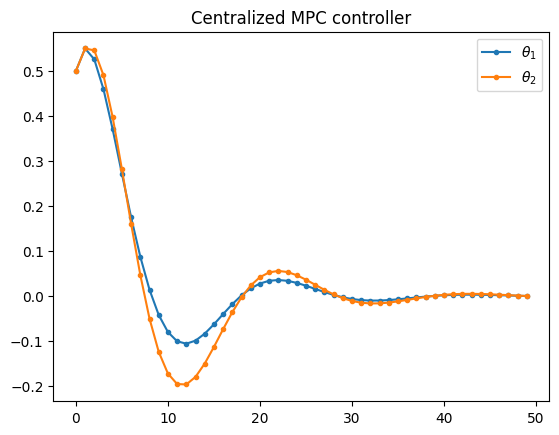

In [53]:
# centralized MPC
x_mpc = np.zeros((Tsim, 1, NX))
x_mpc[0] = x0.T

for t in range(Tsim-1):
  # define optim variables
  x = cp.Variable((NX, T+1))
  u = cp.Variable((NU, T))
  # define objective
  objective = cp.Minimize(sum([cp.quad_form(x[:, i], Q) + cp.quad_form(u[:, i], S) for i in range(T)]))
  # define constraints
  constraints = [x[:, 0] == x_mpc[t].T.squeeze()]  # initial condition
  constraints += [x[:, i+1] == A @ x[:, i] + B @ u[:, i] for i in range(T)]
  constraints += [x[:, -1] == np.zeros((NX))] # terminal constraint
  # solve
  prob = cp.Problem(objective, constraints)
  result = prob.solve()
  # store results
  x_mpc[t+1, 0, :] = x.value[:, 1]

plt.plot(np.arange(0, Tsim), x_mpc[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim), x_mpc[:, 0, 2], ".-", label="$\\theta_2$")
plt.title("Centralized MPC controller")
plt.legend(loc="best")

In [ ]:
# feasibility constraints
I = np.eye(NX*T)

Z = np.eye(NX*(T-1))
Z = np.concatenate((Z, np.zeros((NX*(T-1), NX))), axis=1)
Z = np.concatenate((np.zeros((NX, NX*T)), Z), axis=0)

E1 = np.concatenate((np.eye(NX), np.zeros((NX*T, NX)))) 

Aa = np.kron(np.eye(T, dtype=int), A)   # blkdiag(A, ..., A)
Bb = np.kron(np.eye(T, dtype=int), B)   # blkdiag(B, ..., B)

IZA = I - Z @ Aa
ZB = -Z @ Bb
ZAB = np.concatenate((IZA, ZB), axis=1)

In [ ]:
ZAB.shape

In [42]:
aa = np.ones((3*2,1))
aa.shape
aa.squeeze().shape
aa[:, None].shape

(6, 1, 1)